In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
import datetime
import os
import calendar
from tqdm import tqdm
from tabulate import tabulate 
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1) 

In [ ]:
from dask.distributed import Client
client = Client(memory_limit = '10GB')
client

Client Scheduler: tcp://127.0.0.1:1673 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 40.00 GB


## RQ 1

In [ ]:
df = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'])

"""Converting file to the parquet"""
df.to_parquet('oct_nov.parquet', engine='pyarrow')

In [ ]:
df = dd.read_parquet(path='oct_nov.parquet', engine='pyarrow')

### What�s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).


In order to answer to this question we calculate how many view, add to cart, and purchase operation are made by the customers, and the we divided those values by the number of unique user sessions. In the plot below we shown how many times a particular event is made every 100 user session. How can we see, most of the customers operation during a session are product views.

In [ ]:
Number_user_session = df.user_session.nunique().compute()
Event = df.event_type.value_counts().compute()
Event = Event/Number_user_session

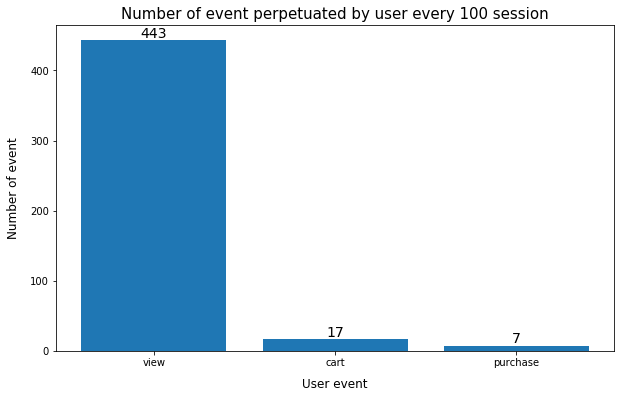

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(Event.index, Event*100)
for i, v in enumerate(Event*100):
    plt.text(i, v, '{0:.0f}'.format(v), horizontalalignment='center', verticalalignment = 'bottom', fontsize = 14)

plt.title('Number of event perpetuated by user every 100 session', fontsize = 15)
plt.xlabel('User event', labelpad = 10, fontsize = 12)
plt.ylabel('Number of event', labelpad = 10, fontsize = 12)
plt.show()

### How many times, on average, a user views a product before adding it to the cart?

We count for every product how many times each customer make a view, a purchase or an add to cart operation. Then we selected only the product that has been added to the cart by at least one customer, and evaluate how many times, on average, a customer view a product, taking the mean of how many times each customers see a product before add it to the cart. 

In average a customers views a product 3 times befor add it to the cart 

In [ ]:
df_1 = dd.concat([df[['user_id', 'product_id']], dd.get_dummies(df[['event_type']].categorize())], axis = 1)

# we count how many operation are made by the custumer for each product
df_1 = df_1.groupby(['user_id', 'product_id']).aggregate('sum').compute()

# select product added to cart
df_1 = df_1[df_1.event_type_cart != 0]


C:\Users\lozzi\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\multi.py:1054: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [ ]:
view_number = (df_1.event_type_view/df_1.event_type_cart).mean()

In [ ]:
print('In avereg an user view a product', '{0:.0f}'.format(view_number), 'times before add it to the cart')

In avereg an user view a product 3 times before add it to the cart


### What�s the probability that products added once to the cart are effectively bought?

The operation made for the previous question are usefull for this one too, so we reuse the work done to product the dataframe df_1. In order to evaluate the probability that a product has to be bought, we select only the product added to the cart, how we done previously, and we take the mean value of the ratio purchase/add to cart.

The result of our analysis show that only the 36% of the product added to the cart are actually bought.

In [ ]:
purchase_prob = (df_1.event_type_purchase/df_1.event_type_cart).mean()

In [ ]:
print('The ' + '{0:.0f}'.format(purchase_prob*100) + '% of the product added to the cart are actually bought' )

The 36% of the product added to the cart are actually bought


### What�s the average time an item stays in the cart before being removed?


In the dataset there are just three events: 'view', 'cart', and 'purchase'. We assume that an object is removed from the cart only when bought. We group by 'user_id' and 'product_id' columns, and then aggregate the time data by mean. we choose the average because for the same couple (user_id, product_id) may be multiple 'view', 'cart', and 'purchase' in different number for each event type. also, we use 'user_id' instead 'user_session', because 'user_session' is an unique user identify which change after unspecified time of inactivity

In [ ]:
# select cart and purchase event
cart = df[df.event_type == 'cart'][['user_id', 'product_id', 'event_time']]
purchase = df[df.event_type == 'purchase'][['user_id', 'product_id', 'event_time']]

In [ ]:
# changing data type in seconds
purchase['Seconds_purchase'] = purchase.event_time.apply(lambda x: x.timestamp(), meta=('Seconds', 'float64'))
cart['Seconds_cart'] = cart.event_time.apply(lambda x: x.timestamp(), meta=('Seconds', 'float64'))

In [ ]:
P = purchase.groupby(['user_id', 'product_id']).Seconds_purchase.mean()
C = cart.groupby(['user_id', 'product_id']).Seconds_cart.mean()

Here we have done the difference between purchase and add to cart event. Then we selected only the difference greater than zero, because a customer could buy a product once and later add it to the cart for another purchase.

We take the mean of the difference between the time in which 'cart' and 'purchase' events are generated. it seems that an iteam stay in a cart, on average, for 3 hours and 28 minutes

In [ ]:
D = (P-C).dropna()

In [ ]:
Seconds = D[D > 0].mean().compute()

In [ ]:
print('in average time an item stay in a cart for '
      +'{0:.0f}'.format(Seconds/(3600))+' hours and '+'{0:.0f}'.format(Seconds%(3600)/(60))+ ' minuts')

in average time an item stay in a cart for 3 hours and 28 minuts


### How much time passes on average between the first view time and a purchase/addition to cart?

How we previusly explained, we choose 'user_id' instead of 'user_session', and we select the first 'view', 'cart', and 'purchase' event for every couple ('user_id', 'product_id'). Then we select the product that the same customer has view, add to cart, and purchase.

Taking the mean time difference between first view event and the first purchase/addition to cart event, we obtained the following result:
- In average a product is added to cart after 24 hours and 6 minutes from the first view

- In average a product is purchased after 29 hours and 42 minutes from the first view


In [ ]:
#select view events
view = df[df.event_type == 'view'][['user_id', 'product_id', 'event_time']]
view['Seconds_view'] = view.event_time.apply(lambda x: x.timestamp(), meta=('Seconds', 'float64'))

In [ ]:
#selecting the minimum value
v = view.groupby(['user_id', 'product_id']).Seconds_view.min().compute()
p = purchase.groupby(['user_id', 'product_id']).Seconds_purchase.min().compute()
c = cart.groupby(['user_id', 'product_id']).Seconds_cart.min().compute()

In [ ]:
# selecting product view, added to cart, and purchased by the same customer
df_2 = pd.concat([v, c, p], axis = 1).dropna()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1883 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1885 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1884 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1888 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1889 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1891 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1890 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:1892 remote=tcp://127.0.0.1:1673>
distributed.comm.tcp - W

In [ ]:
# check the sequential time order
df_2 = df_2[(df_2.Seconds_view < df_2.Seconds_cart) & (df_2.Seconds_cart < df_2.Seconds_purchase)]

In [ ]:
S_1 = (df_2.Seconds_cart - df_2.Seconds_view).mean()

In [ ]:
S_2 = (df_2.Seconds_purchase - df_2.Seconds_view).mean()

In [ ]:
print('In average a product is added to cart after ' +
     '{0:.0f}'.format(S_1/(3600))+' hours and '+'{0:.0f}'.format(S_1%(3600)/60)+ ' minutes from the first view')

In average a product is added to cart after 24 hours and 6 minutes from the first view


In [ ]:
print('In average a product is purchased after ' +
     '{0:.0f}'.format(S_2/(3600))+' hours and '+'{0:.0f}'.format(S_2%(3600)/60)+ ' minutes from the first view')

In average a product is purchased after 29 hours and 42 minutes from the first view


### [RQ2]  
What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.
* Plot the most visited subcategories.
* What are the 10 most sold products per category?

In order to satisfy the request, we choose to read some columns from the datasets and parser date time

In [ ]:
df = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'], usecols = ['event_time', 'event_type', 'category_code', 'product_id'], parse_dates=['event_time'],
date_parser=pd.to_datetime)
df.head()

,event_time,event_type,product_id,category_code
0,2019-10-01 00:00:00+00:00,view,44600062,NaN
1,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater
2,2019-10-01 00:00:01+00:00,view,17200506,furniture.living_room.sofa
3,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook
4,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone


To dealing with NaN values, we decided to drop rows which include NaN values.

In [ ]:
df = df.dropna()
df.head()

,event_time,event_type,product_id,category_code
1,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater
2,2019-10-01 00:00:01+00:00,view,17200506,furniture.living_room.sofa
3,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook
4,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone
5,2019-10-01 00:00:05+00:00,view,1480613,computers.desktop


To query and manipulate on the big datasets faster, we converted data stored in CSV file to Apache Parquet format.

In [ ]:
%%time
# write data into parquet file format
df.to_parquet('RQ2.parquet', engine='pyarrow')

Wall time: 10min 31s


In [ ]:
%%time
# read data from parquet files
df = dd.read_parquet('RQ2.parquet', engine='pyarrow')

Wall time: 782 ms


In [ ]:
df.head()

,event_time,event_type,product_id,category_code
index,,,,
1,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater
2,2019-10-01 00:00:01+00:00,view,17200506,furniture.living_room.sofa
3,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook
4,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone
5,2019-10-01 00:00:05+00:00,view,1480613,computers.desktop


To answer this question, we created 2 new columns 'category' and 'subcategory' from 'category_code' columns

In [ ]:
%%time
df['category'] = df.category_code.apply(lambda row: str(row).split('.')[0], meta=df.category_code)
df['subcategory'] = df.category_code.apply(lambda row: str(row).split('.')[1], meta=df.category_code)

Wall time: 32 ms


In [ ]:
df.head()

,event_time,event_type,product_id,category_code,category,subcategory
index,,,,,,
1,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater,appliances,environment
2,2019-10-01 00:00:01+00:00,view,17200506,furniture.living_room.sofa,furniture,living_room
3,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook,computers,notebook
4,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone,electronics,smartphone
5,2019-10-01 00:00:05+00:00,view,1480613,computers.desktop,computers,desktop


### Q. What are the categories of the most trending products overall?

We are going to find the most products with the most number of views and see which category they belong

In [ ]:
%%time
product_trending_view = df[df.event_type == 'view'].groupby(by=['product_id','category']).event_type.count().compute().\
to_frame('No_of_views').reset_index().sort_values('No_of_views', ascending = False)

Wall time: 1min 45s


In [ ]:
product_trending_view.head()

,product_id,category,No_of_views
679,1004856,electronics,942167
860,1005115,electronics,910725
613,1004767,electronics,861675
7137,4804056,electronics,497431
850,1005105,electronics,473651


we chose 100 products with the most number of views to compare

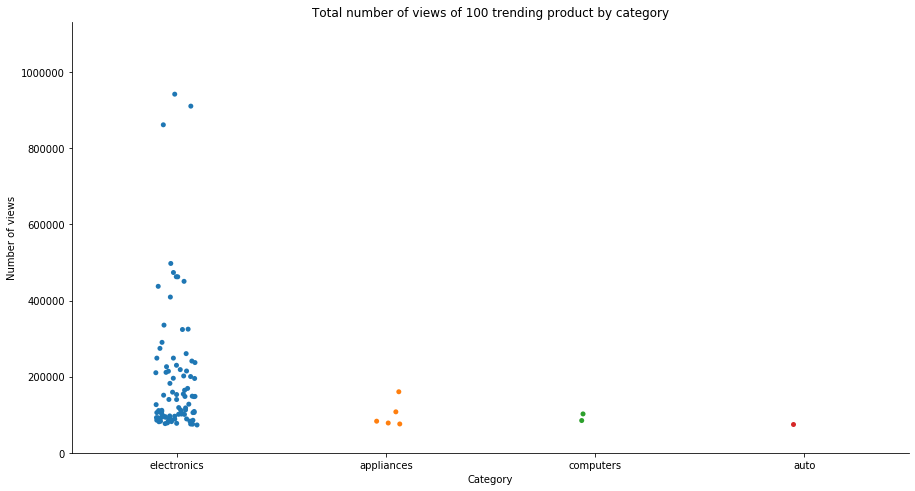

In [ ]:
plot = sns.catplot(x='category',y='No_of_views',  data=product_trending_view.head(100))
plt.title('Total number of views of 100 trending product by category')
plt.xlabel('Category')
plt.ylabel('Number of views')
plt.ylim(0,product_trending_view.head(100)['No_of_views'].max()*1.2);

plot.fig.set_size_inches(15,7)
plt.show()

As we can see, in 100 trending products, **electronics** category has the most number of products which have high number of views. However, **appliances, computers and auto** categories just has some trending products. Each dot represent to a product_id

Another approach to this question, We are going to find the most products with the most number of purchases and see which category they belong

In [ ]:
%%time
product_trending_purchase = df[df.event_type == 'purchase'].groupby(by=['product_id','category']).event_type.count().compute().\
to_frame('No_of_purchases').reset_index().sort_values('No_of_purchases', ascending = False)

Wall time: 1min 20s


In [ ]:
product_trending_purchase.head()

,product_id,category,No_of_purchases
198,1004856,electronics,61265
166,1004767,electronics,44419
286,1005115,electronics,34787
1003,4804056,electronics,30181
186,1004833,electronics,26183


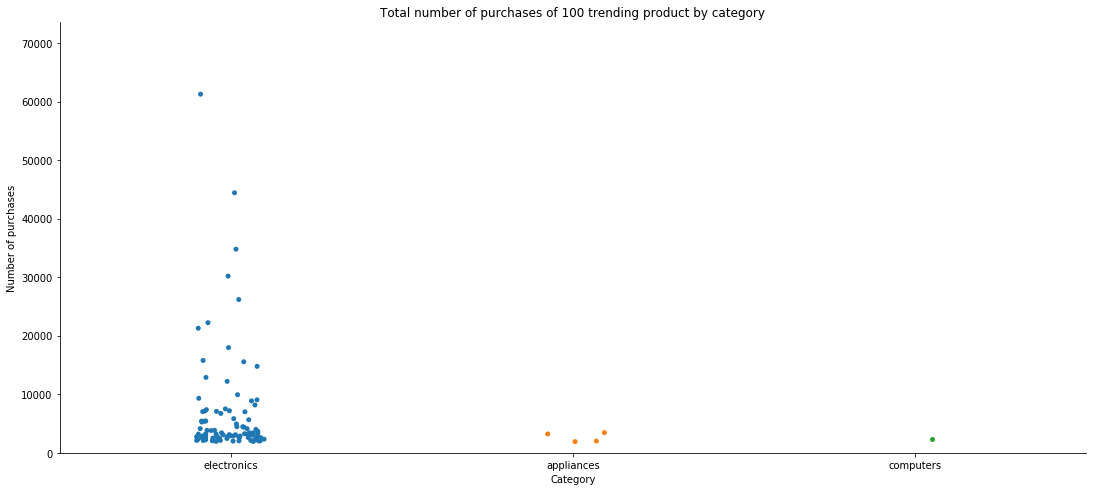

In [ ]:

plot = sns.catplot(x='category',y='No_of_purchases',  data=product_trending_purchase.head(100))
plt.title('Total number of purchases of 100 trending product by category')
plt.xlabel('Category')
plt.ylabel('Number of purchases')
plt.ylim(0,product_trending_purchase.head(100)['No_of_purchases'].max()*1.2);

plot.fig.set_size_inches(18,7)
plt.show()

As we can see, in 100 trending products, **electronics** category has the most number of products which have high number of purchases. However, **appliances and computers** categories just has some trending products. Each dot represent to a product_id

### Q. For each month visualize this information through a plot showing the number of sold products per category.

we convert the event_time to month format

In [ ]:
%%time
df['event_time'] = df['event_time'].dt.month

Wall time: 24 ms


In [ ]:
%%time
sold_product_per_category = df[df.event_type == 'purchase'].groupby(by=['event_time', 'category']).\
    event_type.count().compute().to_frame('No_of_Product_sold').reset_index()


Wall time: 1min 30s


In [ ]:
sold_product_per_category.head()

,event_time,category,No_of_Product_sold
0,10,accessories,1587
1,10,apparel,8002
2,10,appliances,74996
3,10,auto,10620
4,10,computers,27855


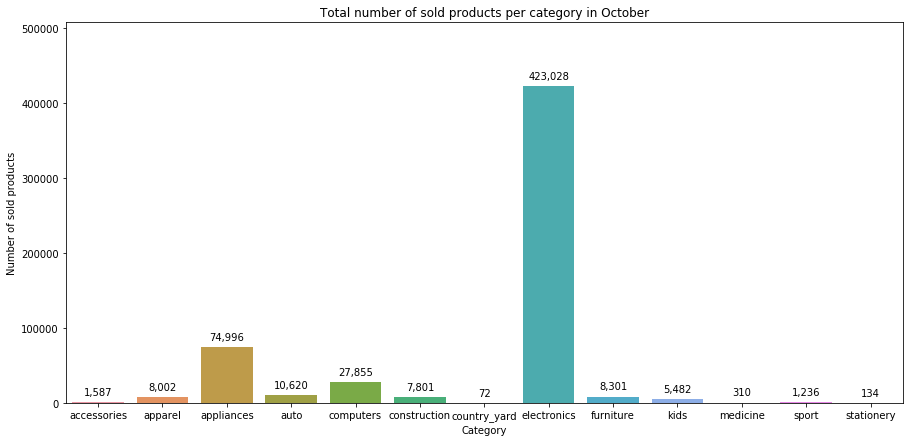

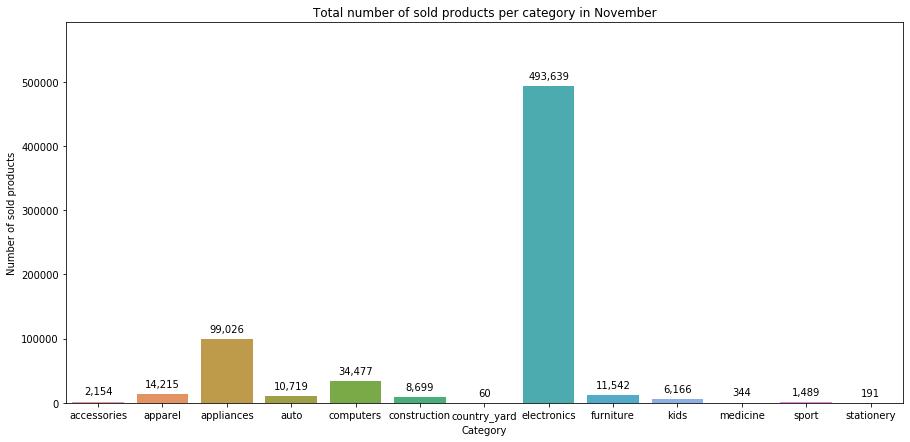

In [ ]:

for month in sold_product_per_category['event_time'].unique():
    category_product = sold_product_per_category[sold_product_per_category['event_time'] == month].reset_index()
    plt.figure(figsize=(15,7))
    plot = sns.barplot(x='category',y='No_of_Product_sold',data=category_product)
    for p in plot.patches:
        plot.annotate(format(p.get_height(), ',.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center',
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

    plt.title('Total number of sold products per category in ' + calendar.month_name[month])
    plt.xlabel('Category')
    plt.ylabel('Number of sold products')
    plt.ylim(0,category_product['No_of_Product_sold'].max()*1.2);

The graphs show the information about number of sold products per category per month. As you can see, electronics categories have the most number of sold products with 423,028 and 493,639 sold products in October and November respectively

### Q. Plot the most visited subcategories.

we count number of visits per subcategory

In [ ]:
%%time
subcategory_visited = df[df.event_type == 'view'].groupby(by=['subcategory']).event_type.count().compute().to_frame('No_of_visit').reset_index()


Wall time: 1min 41s


In [ ]:
len(subcategory_visited)

58

There are 58 subcategories but we choose top 15 subcategories which have the most visited

In [ ]:
subcategory_visited = subcategory_visited.sort_values('No_of_visit', ascending = False).head(15)
subcategory_visited

,subcategory,No_of_visit
39,smartphone,25451835
25,kitchen,9002830
1,audio,3679555
34,shoes,3554471
10,clocks,3267223
28,notebook,3209430
54,video,3162614
18,environment,3114433
0,accessories,2157706
46,tools,1723099


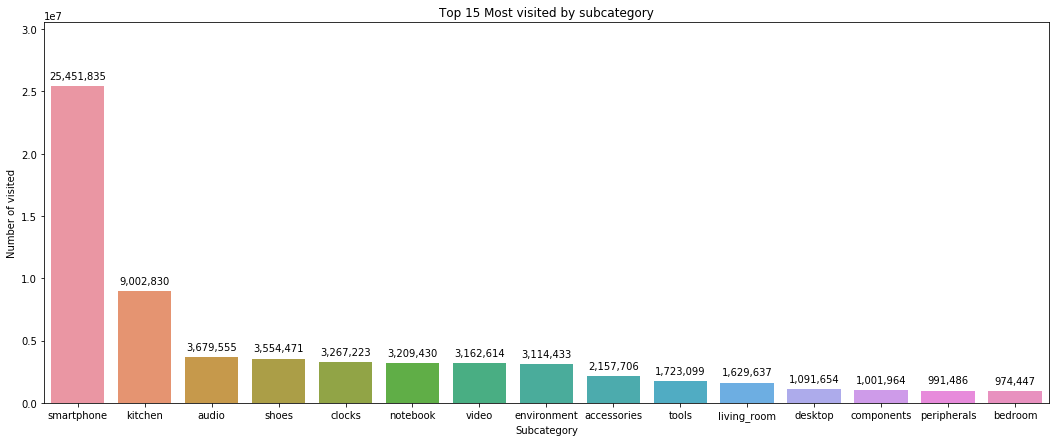

In [ ]:
plt.figure(figsize=(18,7))
plot = sns.barplot(x='subcategory',y='No_of_visit',data=subcategory_visited.head(15))
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Top 15 Most visited by subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Number of visited')
plt.ylim(0,subcategory_visited['No_of_visit'].max()*1.2);

Smartphone is the most visited subcategory with 25,451,835 times in total. Following by Smartphone, kitchen and audio categories have more than 9 million and 3.5 million respectively. By contrast, peripherals and bedroom has the lowest number of visited in top 15 visited categories.

### Q. What are the 10 most sold products per category?

In [ ]:
sold_product_per_category = df[df.event_type == 'purchase'].groupby(by = ['category', 'product_id']).product_id.count().compute().to_frame('No_of_sold_product')
sold_product_per_category

No_of_sold_product
category    product_id                    
accessories 18300229                    10
            18300428                     6
            18300496                    24
            18300589                    11
            18300753                     2
...                                    ...
electronics 100022232                    1
kids        8900499                      1
            10201048                     1
sport       12202950                     1
            100014542                    1

[31284 rows x 1 columns]

In [ ]:
top_10 = sold_product_per_category.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values('No_of_sold_product', ascending=False).head(10))

In [ ]:
print(tabulate(top_10.reset_index(), headers = 'keys', tablefmt = 'github'))

|     | category     |   product_id |   No_of_sold_product |
|-----|--------------|--------------|----------------------|
|   0 | accessories  |     18300155 |                  105 |
|   1 | accessories  |     18300021 |                   87 |
|   2 | accessories  |     28401112 |                   56 |
|   3 | accessories  |     18300460 |                   51 |
|   4 | accessories  |     28400759 |                   50 |
|   5 | accessories  |     18300141 |                   42 |
|   6 | accessories  |     18300214 |                   39 |
|   7 | accessories  |     52900016 |                   38 |
|   8 | accessories  |     18300370 |                   33 |
|   9 | accessories  |     28400912 |                   31 |
|  10 | apparel      |     28720716 |                  101 |
|  11 | apparel      |     54900013 |                  100 |
|  12 | apparel      |     54900004 |                   97 |
|  13 | apparel      |     28718083 |                   93 |
|  14 | apparel      |  

The table above shows us the information about the 10 most sold products per category

## [RQ3]
#### For each category, what�s the brand whose prices are higher on average?
* Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.
* Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.

 In order to satisfy the request, we choose to read some columns from the datasets and parser date time

In [ ]:
%%time
df = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'],
                usecols = [ 'category_code','event_type','brand', 'price'])
df.tail()

Wall time: 2.48 s


,event_type,category_code,brand,price
350811,view,NaN,NaN,277.74
350812,view,apparel.shoes,baden,62.81
350813,view,electronics.smartphone,samsung,167.03
350814,view,appliances.kitchen.refrigerators,samsung,566.27
350815,view,electronics.smartphone,apple,1312.52


To dealing with NaN values, we decided to drop rows which include NaN values.

In [ ]:
df = df.dropna()

To query and manipulate on the big datasets faster, we converted data stored in CSV file to Apache Parquet format.

In [ ]:
%%time
df.to_parquet(r'D:\All_Dataset\EcOMMERSE_dataset_assignment_2\archive/RQ3.parquet', engine='pyarrow')

Wall time: 3min 11s


In [ ]:
%%time
df = dd.read_parquet(r'D:\All_Dataset\EcOMMERSE_dataset_assignment_2\archive/RQ3.parquet', engine='pyarrow')

Wall time: 15.5 s


To answer this question, we created 2 new columns 'category' and 'subcategory' from 'category_code' columns

In [ ]:
%%time
df['category'] = df.category_code.apply(lambda row: str(row).split('.')[0], meta=df.category_code)
df['subcategory'] = df.category_code.apply(lambda row: str(row).split('.')[1], meta=df.category_code)

Wall time: 262 ms


In [ ]:
df.tail()

,event_type,category_code,brand,price,category,subcategory
350809,view,construction.tools.drill,bosch,266.16,construction,tools
350812,view,apparel.shoes,baden,62.81,apparel,shoes
350813,view,electronics.smartphone,samsung,167.03,electronics,smartphone
350814,view,appliances.kitchen.refrigerators,samsung,566.27,appliances,kitchen
350815,view,electronics.smartphone,apple,1312.52,electronics,smartphone


### Q. For each category, what�s the brand whose prices are higher on average?
Here we are getting series with avg value of price per category, So that we can compare and find higher on average


In [ ]:
%%time
series_of_avg_per_category = df.groupby(by = 'category').price.mean().compute()

Wall time: 3min 40s


In [ ]:
"""Avg price per category"""

series_of_avg_per_category

category
accessories     61.089599 
apparel         83.170833 
appliances      232.933432
auto            155.098119
computers       535.652599
construction    188.182304
country_yard    278.900357
electronics     422.767489
furniture       231.394546
kids            162.827606
medicine        52.210173 
sport           412.999575
stationery      32.298865 
Name: price, dtype: float64

In [ ]:
"""This is dataframe with two index with category and brand, Then we got mean over price"""
x = df.groupby(by = ['category', 'brand']).agg({'price' : ['mean']}).compute()
x.reset_index()

,category,brand,price
,,,mean
0,accessories,a-elita,45.051727
1,accessories,acer,49.623852
2,accessories,acron,15.350086
3,accessories,apple,131.677895
4,accessories,asus,15.726349
5,accessories,baden,43.200870
6,accessories,bestlife,13.979799
7,accessories,bestway,17.902513
8,accessories,cameron,13.154472


In [ ]:
"""Let's compare the data and If it is higher on average, then let's take in the column (price, mean) """

above_avg = x.groupby(level=0, group_keys=False).apply(lambda x : x[x['price']['mean'] > series_of_avg_per_category[x.index[0][0]]])

In [ ]:
above_avg.reset_index()

,category,brand,price
,,,mean
0,accessories,apple,131.677895
1,accessories,coccinelle,366.095776
2,accessories,coleman,64.652153
3,accessories,delsey,83.968471
4,accessories,dewalt,111.261238
5,accessories,dometic,230.457384
6,accessories,ezetil,140.484950
7,accessories,flambeau,86.577243
8,accessories,incase,108.090000


#### Conclusion of above question -
let's take eg. Avg of category accesories is 61.08, so taken category and brand as a index , we have brand which are having mean value greater than 61.08.
in this way we have brand which having higher on avg price

### Q Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

In [ ]:
def visualize_mean_by_brand(category_name):
    """
    Function name :visualize_mean_by_brand
    Inputs : Category name
    output : plot 
    """
    
    plt.figure(figsize=(20,10))

    temp = df[(df['category'] == category_name) & (df['event_type']=='purchase')]
    dataframe_for_plot = temp.groupby(by = ['category', 'brand']).price.mean().compute().sort_values(ascending = False).nlargest(20)
    dataframe_for_plot = dataframe_for_plot.reset_index()
    plt.figure(figsize=(18,7))
    plot = sns.barplot(x='brand',y='price',data=dataframe_for_plot)
    for p in plot.patches:
        plot.annotate(format(p.get_height(), ',.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center',
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

    plt.title('Top 50 brand of given category '+ str(category_name))
    plt.xlabel('Brand')
    plt.xticks(rotation=45)
    plt.ylabel('Average price')
    plt.ylim(0,dataframe_for_plot['price'].max()*1.2)    
    plt.show()
    

So, We have given category name as a "sport", and we can see that we have all brands in sport, 
Below plot shows Decreasing order of average price of brand present in category sport

0     appliances  
1     computers   
2     electronics 
3     apparel     
4     furniture   
5     construction
6     kids        
7     auto        
8     sport       
9     accessories 
10    medicine    
11    stationery  
12    country_yard
Name: category, dtype: object
Please enter the category name to visualize the plot by brand mean: appliances


<Figure size 1440x720 with 0 Axes>

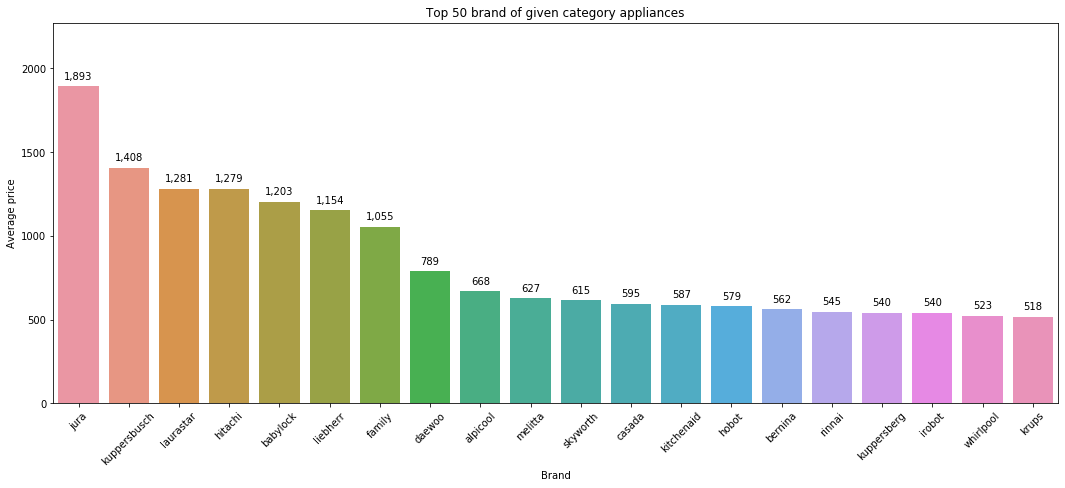

In [ ]:

print(df['category'].unique().compute())

category_name = input('Please enter the category name to visualize the plot by brand mean: ')
dataframe_for_plot = visualize_mean_by_brand(category_name)

### Q Find, for each category, the brand with the highest average price. Return all the results in ascending order by price

In [ ]:
x.groupby(level=0, group_keys=False).apply(lambda y: y.sort_values(by = [('price','mean')], ascending=False).head(1)).sort_values(by = [('price','mean')])

,,price
,,mean
category,brand,
medicine,omron,52.655490
stationery,xerox,66.670000
accessories,weekend,690.505716
country_yard,viking,746.174484
apparel,sergiorossi,1018.397273
auto,schneider,1110.101860
kids,hartan,1801.820000
furniture,senspa,1976.539630


As we can see in table we have 13 category and for each category we have multiple brand,
so from that brand we have choosen those with highest value and sorted in ascending order

## [RQ4]

How much does each brand earn per month? Write a function that given the name of a brand in input returns, for each month, its profit. Is the average price of products of different brands significantly different?

* Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [ ]:
%%time
df = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'], usecols = ['event_time', 'event_type', 'brand', 'price'], parse_dates=['event_time'],
date_parser=pd.to_datetime)
df.head()

Wall time: 9.4 s


,event_time,event_type,brand,price
0,2019-10-01 00:00:00+00:00,view,shiseido,35.79
1,2019-10-01 00:00:00+00:00,view,aqua,33.20
2,2019-10-01 00:00:01+00:00,view,NaN,543.10
3,2019-10-01 00:00:01+00:00,view,lenovo,251.74
4,2019-10-01 00:00:04+00:00,view,apple,1081.98


In [ ]:
df = df.dropna()
df.head()

,event_time,event_type,brand,price
0,2019-10-01 00:00:00+00:00,view,shiseido,35.79
1,2019-10-01 00:00:00+00:00,view,aqua,33.20
3,2019-10-01 00:00:01+00:00,view,lenovo,251.74
4,2019-10-01 00:00:04+00:00,view,apple,1081.98
5,2019-10-01 00:00:05+00:00,view,pulser,908.62


In [ ]:
%%time
df['event_time'] = df['event_time'].dt.month
df.head()

Wall time: 6.98 s


,event_time,event_type,brand,price
0,10,view,shiseido,35.79
1,10,view,aqua,33.20
3,10,view,lenovo,251.74
4,10,view,apple,1081.98
5,10,view,pulser,908.62


In [ ]:
%%time
# write data into parquet file format
df.to_parquet('RQ4.parquet', engine='pyarrow')

Wall time: 10min 31s


In [ ]:
%%time
# read data from parquet files
df = dd.read_parquet('RQ4.parquet', engine='pyarrow')

Wall time: 541 ms


In [ ]:
df.head()

,event_time,event_type,brand,price
index,,,,
0,10,view,shiseido,35.79
1,10,view,aqua,33.20
3,10,view,lenovo,251.74
4,10,view,apple,1081.98
5,10,view,pulser,908.62


###  How much does each brand earn per month?


In [ ]:
%%time
income_per_month = df[df.event_type == 'purchase'].groupby(by = ['event_time','brand']).price.sum().compute().\
    to_frame('revenue').reset_index()

Wall time: 32.7 s


In [ ]:
income_per_month

,event_time,brand,revenue
0,10,a-case,275.26
1,10,acer,3576719.52
2,10,acme,4111.93
3,10,adamex,22883.39
4,10,adata,3870.63
...,...,...,...
4464,11,qplay,144.15
4465,11,triumph,4.37
4466,11,westone,372.74
4467,11,targus,42.76


In [ ]:
income_per_month[income_per_month['event_time'] == 10].sort_values('revenue', ascending=False).head(10)

,event_time,brand,revenue
25,10,apple,1.112093e+08
391,10,samsung,4.640753e+07
489,10,xiaomi,9.194033e+06
207,10,huawei,4.883422e+06
1,10,acer,3.576720e+06
260,10,lg,3.387888e+06
265,10,lucente,3.124113e+06
414,10,sony,2.478197e+06
325,10,oppo,2.412960e+06
259,10,lenovo,1.752639e+06


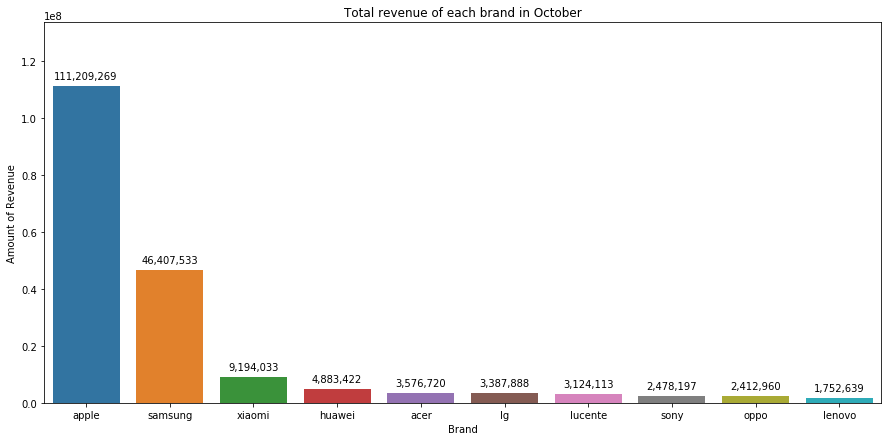

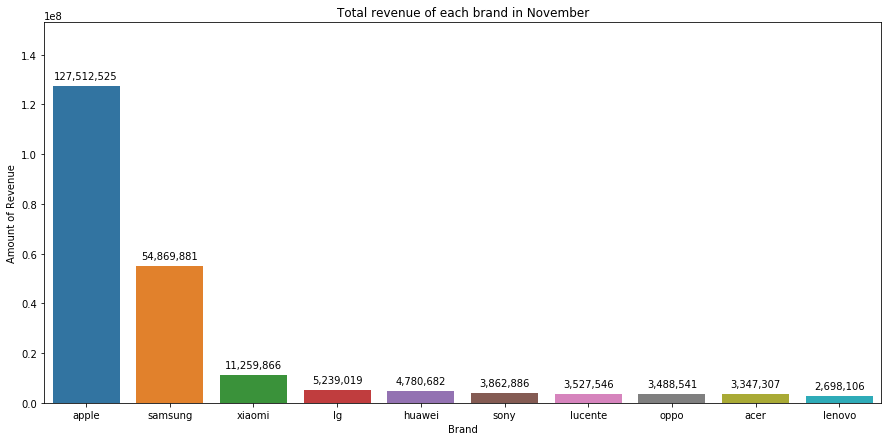

In [ ]:
for month in income_per_month['event_time'].unique():
    
    brand_revenue = income_per_month[income_per_month['event_time'] == month].sort_values('revenue', ascending=False).head(10)
    
    
    plt.figure(figsize=(15,7))
    plot = sns.barplot(x='brand',y='revenue',data=brand_revenue)
    for p in plot.patches:
        plot.annotate(format(p.get_height(), ',.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center',
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

    plt.title('Total revenue of each brand in ' + calendar.month_name[month])
    plt.xlabel('Brand')
    plt.ylabel('Amount of Revenue')
    plt.ylim(0,brand_revenue['revenue'].max()*1.2);

### Write a function that given the name of a brand in input returns, for each month, its profit

In [ ]:
purchase_df = df[(df.event_type == 'purchase')].groupby(by = ['event_time','brand']).price.sum().compute().\
    to_frame('revenue').reset_index()

In [ ]:
def get_profit(brand_name):
    profit = purchase_df[purchase_df.brand == brand_name]
    return profit
    

In [ ]:
%%time
profit = get_profit('samsung')
profit

Wall time: 2 ms


,event_time,brand,revenue
391,10,samsung,46407532.61
2405,11,samsung,54869880.87


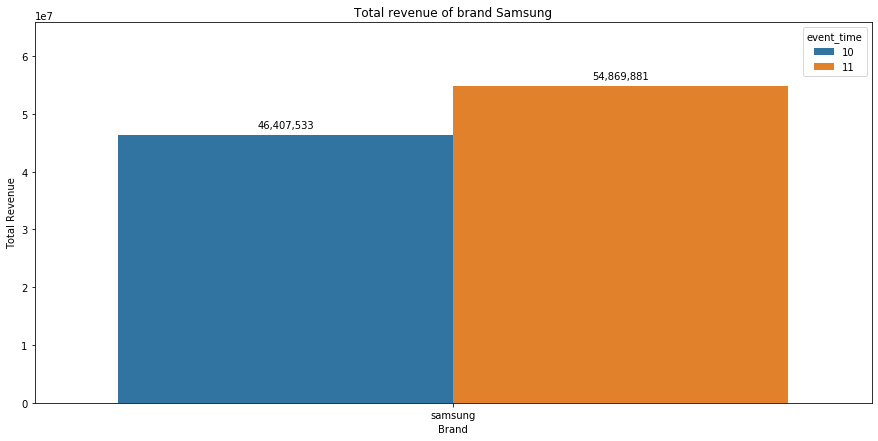

In [ ]:
plt.figure(figsize=(15,7))
plot = sns.barplot(x='brand',y='revenue', hue = 'event_time', data = profit)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
plt.title('Total revenue of brand Samsung')
plt.xlabel('Brand')
plt.ylabel('Total Revenue')
plt.ylim(0,profit['revenue'].max()*1.2);

### Is the average price of products of different brands significantly different?

In [ ]:
avg_price_of_brand = df.groupby('brand').price.mean().compute().to_frame('mean_price').reset_index()


In [ ]:
avg_price_of_brand.sort_values('mean_price', ascending = False)

,brand,mean_price
2283,pinarello,2533.238401
3901,nordictrack,2522.590000
4000,kessler,2372.000000
4177,yjfitness,2344.980000
2057,climadiff,2261.951167
...,...,...
2249,heinz,1.113252
4111,clevercompany,1.030000
3871,freshfruit,1.030000
3935,vakosa,0.990000


In [ ]:
avg_price_of_brand.reset_index().drop(['index'], axis = 1).agg(['mean', 'std'])

,mean_price
mean,173.747521
std,279.311420


The average value of the mean price of brand is much lower then the standard deviation 
so we can say that the overall average price of products of different brands are significantly different


Text(0, 0.5, 'Avarage price of products')

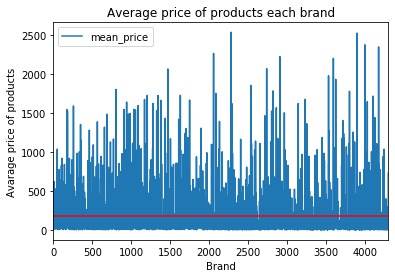

In [ ]:
avg_price_of_brand.plot()
plt.axhline(y=avg_price_of_brand.mean_price.mean(), color='r', linestyle='-')
plt.title('Average price of products each brand')
plt.xlabel('Brand')
plt.ylabel('Avarage price of products')

As we can see in the plot, there are many brand having the average price of products higher than the overall mean in the red line. 
As the conclusion,  the average price of products of different brands is significantly different

### Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).


In [ ]:
losses = []
for brand in purchase_df.brand.unique():
    profit = get_profit(brand)
    profit['percentage'] = profit['revenue'].pct_change()
    loss = profit[profit.percentage.notna()][['brand', 'percentage']]
    losses.append(loss)

losses = pd.concat(losses)
losses.sort_values('percentage')

D:\Jupyter\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,brand,percentage
3609,jonnesway,-0.966243
2641,sunfull,-0.960000
4197,evga,-0.958997
4053,illumico,-0.957246
3339,ventura,-0.950434
...,...,...
2903,asm,107.001142
2963,pinskdrev,114.462580
2126,dinastia,132.585617
3120,delta,773.262125


As we can see, , by using the function that we created, we have found top 3 brands that have suffered the biggest losses in earnings between one month and the next are
**Jonnesway, sunfull and evga**

In [ ]:
most_losses = purchase_df[(purchase_df.brand == 'jonnesway') | (purchase_df.brand == 'sunfull') | (purchase_df.brand == 'evga')]

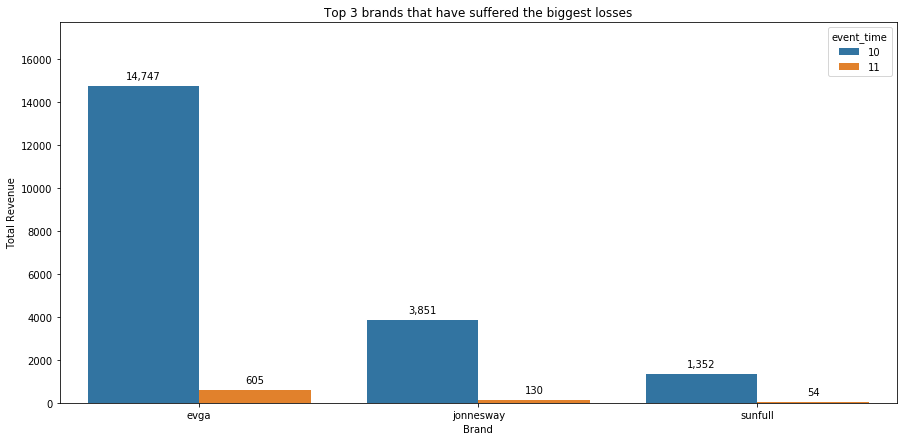

In [ ]:
plt.figure(figsize=(15,7))
plot = sns.barplot(x='brand',y='revenue', hue = 'event_time', data = most_losses)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
plt.title('Top 3 brands that have suffered the biggest losses')
plt.xlabel('Brand')
plt.ylabel('Total Revenue')
plt.ylim(0,most_losses['revenue'].max()*1.2);

##  [RQ5]
### In what part of the day is your store most visited? Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. Create a plot that for each day of the week show the hourly average of visitors your store has.

In [ ]:
RQ_5 = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'],
                usecols = ['event_time','event_type'],
                     parse_dates = ['event_time'],
                      date_parser =pd.to_datetime,)

RQ_5.tail()

,event_time,event_type
350811,2019-11-30 23:59:58+00:00,view
350812,2019-11-30 23:59:58+00:00,view
350813,2019-11-30 23:59:59+00:00,view
350814,2019-11-30 23:59:59+00:00,view
350815,2019-11-30 23:59:59+00:00,view


To dealing with NaN values, we decided to drop rows which include NaN values.

In [ ]:
RQ_5 = RQ_5.dropna()

In [ ]:
%%time
RQ_5.to_parquet('RQ5.parquet', engine='pyarrow')

Wall time: 0 ns


In [ ]:
%%time
rq_5 = dd.read_parquet('RQ5.parquet', engine='pyarrow')

Wall time: 570 ms


In [ ]:
rq_5.tail()

,event_time,event_type
350811,2019-11-30 23:59:58+00:00,view
350812,2019-11-30 23:59:58+00:00,view
350813,2019-11-30 23:59:59+00:00,view
350814,2019-11-30 23:59:59+00:00,view
350815,2019-11-30 23:59:59+00:00,view


###  In what part of the day is your store most visited ?

We will count number of user visited from 0 to 24 hour, using grouby operation

In [ ]:
temp_df = rq_5[rq_5['event_type'] == 'view']
temp_df_1 = temp_df.groupby(by = [temp_df['event_time'].dt.hour])

In [ ]:
Time_and_views = temp_df_1.agg({'event_type': ['count']}).compute()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51895 remote=tcp://127.0.0.1:51812>


In [ ]:
"""Calculated time at which we have maximum views """
Time_and_views.reset_index(inplace = True)

#### From this dataframe we can see that at hour 16, we have maximum views

In [ ]:
Time_and_views

,event_time,event_type
,,count
0,0,729308
1,1,1350441
2,2,2632243
3,3,3740363
4,4,4692790
5,5,5234702
6,6,5468082
7,7,5555772
8,8,5701665


(0, 8725140.0)

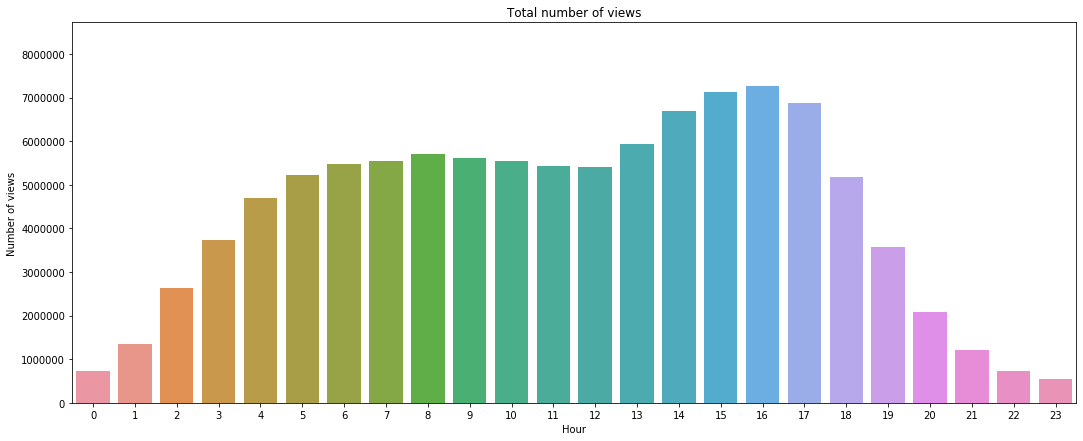

In [ ]:
"""Let's plot the Hour V/s Number of views graph"""

plt.figure(figsize=(18,7))
plot = sns.barplot(x=Time_and_views['event_time'],y=Time_and_views['event_type']['count'])

plt.title('Total number of views')
plt.xlabel('Hour')
plt.ylabel('Number of views')
plt.ylim(0,Time_and_views['event_type']['count'].max()*1.2)

### Create a plot that for each day of the week show the hourly average of visitors your store has

We will calculate number of views on the day of week at each hour, And then we will plot graph.

In [ ]:
temp_df = rq_5[rq_5['event_type'] == 'view']

In [ ]:
temp_df.tail()

,event_time,event_type
350811,2019-11-30 23:59:58+00:00,view
350812,2019-11-30 23:59:58+00:00,view
350813,2019-11-30 23:59:59+00:00,view
350814,2019-11-30 23:59:59+00:00,view
350815,2019-11-30 23:59:59+00:00,view


In [ ]:
temp_df['Value_is_one'] = temp_df.event_type.apply(lambda row:  1 if row == 'view' else 1)

D:\Anaconda_install\lib\site-packages\dask\dataframe\core.py:3219: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('event_type', 'int64'))

  warnings.warn(meta_warning(meta))


In [ ]:
temp_df.tail()

,event_time,event_type,Value_is_one
350811,2019-11-30 23:59:58+00:00,view,1
350812,2019-11-30 23:59:58+00:00,view,1
350813,2019-11-30 23:59:59+00:00,view,1
350814,2019-11-30 23:59:59+00:00,view,1
350815,2019-11-30 23:59:59+00:00,view,1


In [ ]:
temp_df_1 = temp_df.groupby([temp_df['event_time'].dt.day_name(),temp_df['event_time'].dt.hour]).\
        agg({'Value_is_one' :['sum']}).compute()


In [ ]:
temp_df_1

Value_is_one
                               sum
event_time event_time             
Friday     0                161958
           1                281338
           2                535778
           3                694692
           4                797108
...                            ...
Wednesday  19               413050
           20               226651
           21               130818
           22                83975
           23                65823

[168 rows x 1 columns]

In [ ]:
import calendar
from collections import Counter

cal = calendar.Calendar()
year = 2019
month = 10
count1 = Counter(d.strftime('%A') for d in cal.itermonthdates(year, month) if d.month==month)
year = 2019
month = 11
count2 =  Counter(d.strftime('%A') for d in cal.itermonthdates(year, month) if d.month==month)

In [ ]:
days_name_count = dict(count1 + count2)

In [ ]:
temp_df_1['Avg_hourly_value'] = temp_df_1.groupby(level=0, group_keys=False).apply(lambda x : x['Value_is_one']['sum']/days_name_count[x.index[0][0]])

In [ ]:
temp_df_1_ = temp_df_1.drop(('Value_is_one', 'sum'), axis = 1)

In [ ]:
""" Here we have taken ratioof No of views to the No of days present in our dataset 
     eg.  Let's take example of Friday 
     We have No of views = 161958 
             No of Friday in Oct and Nov Dataset 9
             By taking ratio we got hourly avg """

temp_df_1_

Avg_hourly_value
                                      
event_time event_time                 
Friday     0              17995.333333
           1              31259.777778
           2              59530.888889
           3              77188.000000
           4              88567.555556
...                                ...
Wednesday  19             45894.444444
           20             25183.444444
           21             14535.333333
           22              9330.555556
           23              7313.666667

[168 rows x 1 columns]

##### From the figure we conlude that we have Maximum views per hour  on sunday 17 o'clock


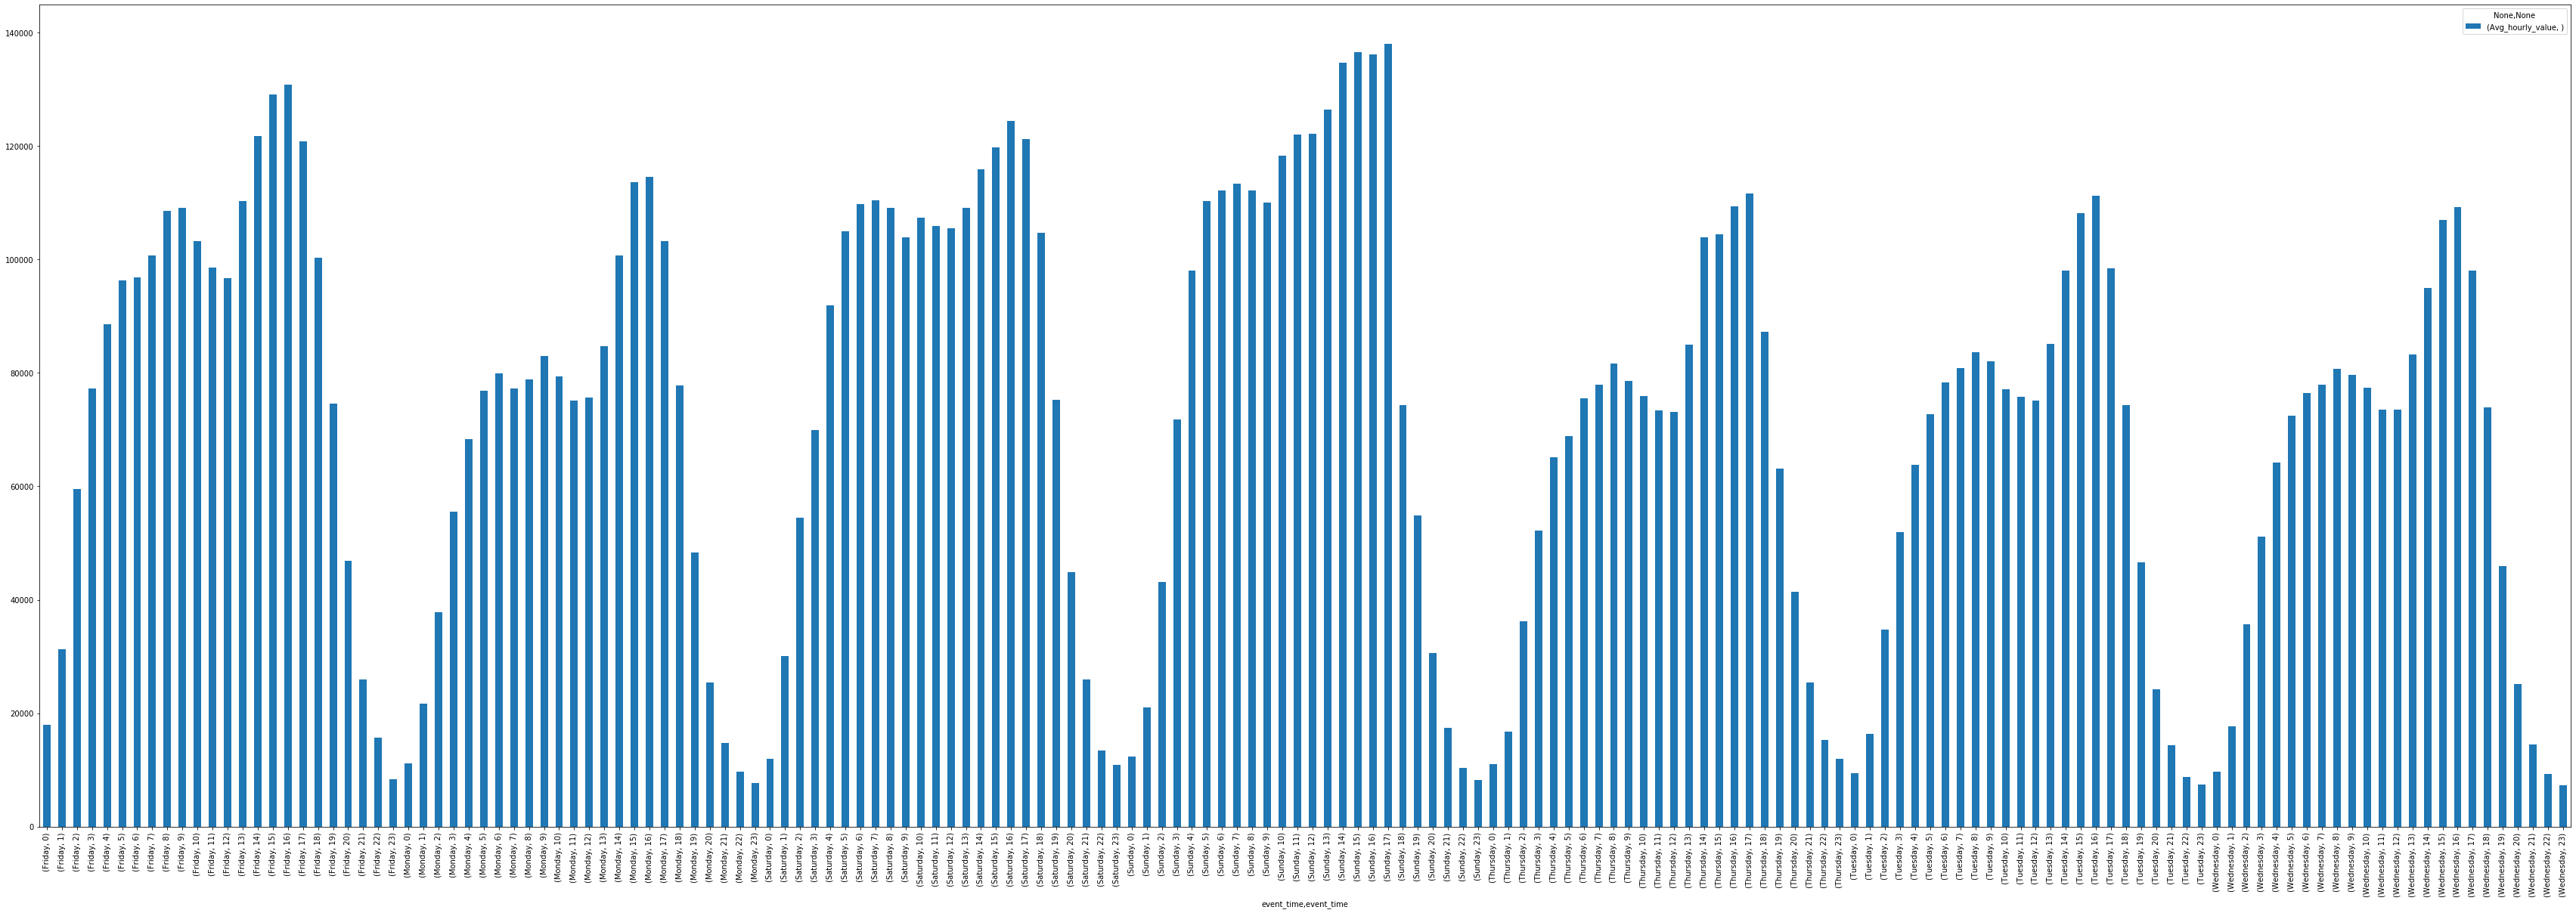

In [ ]:
""" We can't see this fugure correctly in jupyter because of 168 x-labels, So we have stored the figure as output.png"""
temp_fig = temp_df_1_.plot.bar(figsize=(60,20))

In [ ]:

fig = temp_fig.get_figure()
fig.savefig("output.png")

In [ ]:
days = list(calendar.day_name)
days

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

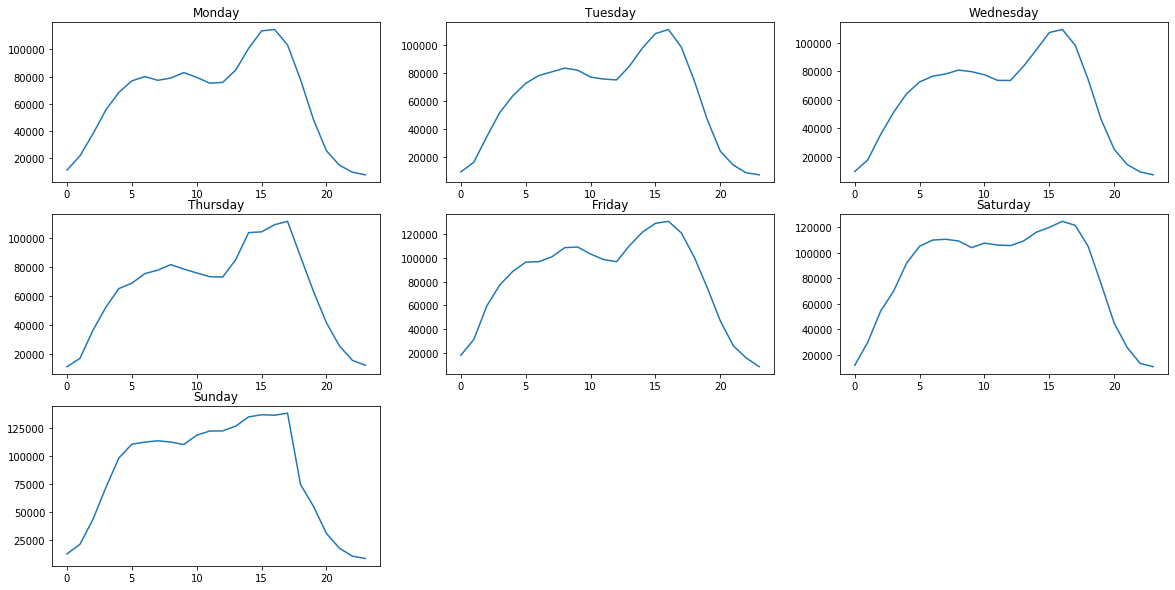

In [ ]:
""" Let's visualize graph of each day """

plt.figure(figsize=(20,10))
for i, day in enumerate(days):
    plt.subplot(3, 3, i+1)
    plt.plot(temp_df_1_.loc[day])
    plt.title(day)

As we can see from the below dataframe, We have max value at 17 on Sunday 

In [ ]:
"""Maximum of hourly average value of each day in week """
max_of_the_day = temp_df_1_.groupby(level=0, group_keys=False).apply(lambda y: y.sort_values(by = ['Avg_hourly_value'], ascending=False).head(1)).sort_values(by = ['Avg_hourly_value'])

In [ ]:
max_of_the_day

,,Avg_hourly_value
,,
event_time,event_time,
Wednesday,16,109187.444444
Tuesday,16,111190.111111
Thursday,17,111695.555556
Monday,16,114629.500000
Saturday,16,124433.000000
Friday,16,130764.444444
Sunday,17,137994.250000


## RQ6
### The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited. What's the conversion rate of your online store?
* Find the overall conversion rate of your store.
* Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

In [ ]:
df = dd.read_csv(['2019-Oct.csv', '2019-Nov.csv'],
                usecols= ['category_code', 'product_id', 'event_type'])

df.tail()

,event_type,product_id,category_code
350811,view,15700137,NaN
350812,view,28719425,apparel.shoes
350813,view,1004833,electronics.smartphone
350814,view,2701706,appliances.kitchen.refrigerators
350815,view,1004233,electronics.smartphone


In [ ]:
%%time
df.to_parquet('RQ6.parquet', engine='pyarrow')

Wall time: 2min 54s


In [ ]:
%%time
df = dd.read_parquet('RQ6.parquet', engine='pyarrow')

Wall time: 174 ms


In [ ]:
df =df.dropna()

In [ ]:
Total_no_of_views = len(df[df['event_type'] == 'view'])

In [ ]:
Total_no_of_purchase = len(df[df['event_type'] == 'purchase'])

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51853 remote=tcp://127.0.0.1:51689>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51855 remote=tcp://127.0.0.1:51643>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51860 remote=tcp://127.0.0.1:51643>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51859 remote=tcp://127.0.0.1:51689>


##### As we can see overall conversion rate is 1.78 %

In [ ]:
conversion_rate = (Total_no_of_purchase/Total_no_of_views) * 100

In [ ]:
conversion_rate

1.782118768133218

### Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

In [ ]:
""" Our approch to find conversion rate of each category will be to find  views and purchase per category and then take ratio
    of that"""

In [ ]:
df.head()

,event_type,product_id,category_code
1,view,3900821,appliances.environment.water_heater
2,view,17200506,furniture.living_room.sofa
3,view,1307067,computers.notebook
4,view,1004237,electronics.smartphone
5,view,1480613,computers.desktop


In [ ]:
%%time
df['category'] = df.category_code.apply(lambda row: str(row).split('.')[0], meta=df.category_code)

Wall time: 34 ms


In [ ]:
New_df_ = df.groupby(by = ['category', 'event_type']).event_type.count().compute()

In [ ]:
New_df_ =   New_df_.unstack().reset_index()

In [ ]:
New_df_

event_type,category,cart,purchase,view
0,accessories,8060,3741,616475
1,apparel,54290,22217,4477518
2,appliances,445181,174022,12837916
3,auto,48229,21339,2157706
4,computers,145266,62332,6297977
5,construction,46727,16500,1759762
6,country_yard,421,132,31255
7,electronics,2198460,916667,37026582
8,furniture,43896,19843,3295250
9,kids,23353,11648,1292002


In [ ]:
""" Calculating conversion rate"""
New_df_['conversion_rate']= New_df_.apply(lambda x : (x['purchase']/ x['view'])*100, axis = 1)

In [ ]:
"""Soring dataframe in descending order"""
New_df_ = New_df_.sort_values(by = ['conversion_rate'], ascending =False)

In [ ]:
New_df_ = New_df_.reset_index()

In [ ]:
New_df_

event_type,index,category,cart,purchase,view,conversion_rate
0,7,electronics,2198460,916667,37026582,2.475700
1,10,medicine,1796,654,34738,1.882665
2,12,stationery,750,325,19323,1.681933
3,2,appliances,445181,174022,12837916,1.355532
4,4,computers,145266,62332,6297977,0.989715
5,3,auto,48229,21339,2157706,0.988967
6,5,construction,46727,16500,1759762,0.937627
7,9,kids,23353,11648,1292002,0.901547
8,11,sport,6798,2725,415087,0.656489
9,0,accessories,8060,3741,616475,0.606837


We have done bar plot of category verses purchase from the New_df_ ( DataFrame)
And on the top of each bar we have shown conversion rate.
####  As we can see from the figure though medicine and stationary has lower number of views but higher conversion rate compare to appliances, computers etc

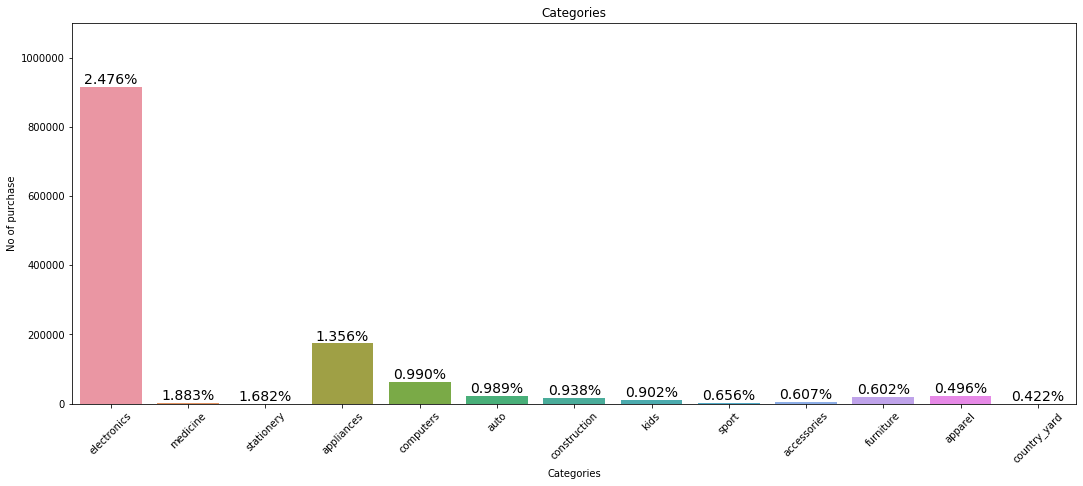

In [ ]:
plt.figure(figsize=(18,7))
plot = sns.barplot(x='category',y='purchase',data=New_df_)
    
for i, v in enumerate(New_df_['conversion_rate']):
    plt.text(i,New_df_['purchase'][i] , '{0:.3f}'.format(v) + '%', horizontalalignment='center', verticalalignment = 'bottom', fontsize =14) 
             
plt.title('Categories')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('No of purchase')
plt.ylim(0,New_df_['purchase'].max()*1.2)    
plt.show()

## [RQ7] 

The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers.
* Prove that the pareto principle applies to your store.

We use dask.dataframe to load dataset

To tackle this question, we read csv files with 3 columns user_id, event_type and price

In [ ]:
%%time
df = dd.read_csv([r'D:\All_Dataset\EcOMMERSE_dataset_assignment_2\archive\2019-Oct.csv', 
                  r'D:\All_Dataset\EcOMMERSE_dataset_assignment_2\archive\2019-Nov.csv'],
                 usecols = ['user_id', 'event_type', 'price'])
df.head()

Wall time: 4.15 s


,event_type,price,user_id
0,view,35.79,541312140
1,view,33.20,554748717
2,view,543.10,519107250
3,view,251.74,550050854
4,view,1081.98,535871217


We delete all rows containing NaN values

In [ ]:
df = df.dropna()
df.head()

,event_type,price,user_id
0,view,35.79,541312140
1,view,33.20,554748717
2,view,543.10,519107250
3,view,251.74,550050854
4,view,1081.98,535871217


We write dataset into partquet format files to manipulate the dataset faster

In [ ]:
%%time
# write data into parquet file format
df.to_parquet('RQ7.parquet', engine='pyarrow')

Wall time: 3min 14s


In [ ]:
%%time
# read data from parquet files
df = dd.read_parquet(r'D:\All_Dataset\EcOMMERSE_dataset_assignment_2\archive\RQ7.parquet', engine='pyarrow')

Wall time: 301 ms


we are quering users with their payments

In [ ]:
user_payments = df[df.event_type == 'purchase'].groupby('user_id').price.sum().compute().\
    to_frame('payments').reset_index().sort_values('payments', ascending = False)

In [ ]:
user_payments

,user_id,payments
47,512386086,344153.29
1522,515384420,303144.24
575,513117637,266331.24
2514,519267944,265569.52
514530,518514099,203986.07
...,...,...
70726,512741995,0.88
659813,517557126,0.87
636622,524830675,0.87
612054,513378422,0.79


In [ ]:
"""Let's store our price data in the descending order in list"""
user_price = list(user_payments['payments'])

### Now we sum the payments of 20% number of users who pay the highest amount of money

In [ ]:
n = int( 0.2 * len(user_payments))

In [ ]:
payments_of_20per_customer = user_payments.payments.head(n).sum()
payments_of_20per_customer

364222233.81

The total payment of all customers

In [ ]:
payments_total = user_payments.payments.sum()
payments_total

505152392.7699998

In [ ]:
""" 20 % of customer contribute around 72.1% revenue"""
str((payments_of_20per_customer/payments_total ) * 100 ) + '%'

'72.10145671344637%'

we can say that 20% customer contributes 72,1% the total revenue of store

### Now let's try to find how many customer contribute 80 % of total revenue

In [ ]:
pauyment_80_percent = payments_total*0.8

In [ ]:
count = 0
for i in range(len(user_price)):
    count = count + user_price[i]
    if count >= pauyment_80_percent:
        no_user_coontrubute = len(user_price[:i])
        print('we got it')
        break
    

we got it


In [ ]:
""" We can see that 28.11 % contribute to 80% of total income"""
str(no_user_coontrubute/len(user_price) * 100 ) + '%'

'28.116764878776145%'

we can say that 28.11% customer contributes 80% the total revenue of store